<a href="https://colab.research.google.com/github/MamMates/ml-food-rating/blob/main/MamMates_Food_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MamMates - Food Classification

Food Classification using CNN

## Prerequisite


https://pypi.org/project/gdown





In [2]:
!pip install gdown -q

## Import neccessary library

In [1]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50V2
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras import Input, Model
from keras.regularizers import l2
from google.colab import files
import tensorflow as tf
import numpy as np
import tempfile
import zipfile
import shutil
import gdown
%matplotlib inline

In [3]:
np.random.seed(42)

## Download dataset

In [4]:
url = "https://drive.google.com/file/d/1xZ-WVmeu90QOc5m8OTmj9Ee6rT1xcm58/view?usp=drive_link"
gdown.download(url, quiet=True, fuzzy=True)

'Dataset.zip'

In [5]:
dataset_path = "Dataset.zip"
extract_location = "/dataset"
zip_extractor = zipfile.ZipFile(dataset_path, 'r')
zip_extractor.extractall(extract_location)
zip_extractor.close()

In [6]:
import os
for root, dirs, _ in os.walk(extract_location):
  for i in dirs:
    print(os.path.join(root, i))

/dataset/Dataset Rating Makanan
/dataset/Dataset Rating Makanan/Rating 2
/dataset/Dataset Rating Makanan/Rating 1
/dataset/Dataset Rating Makanan/Rating 3
/dataset/Dataset Rating Makanan/Rating 2/validation
/dataset/Dataset Rating Makanan/Rating 2/train
/dataset/Dataset Rating Makanan/Rating 2/test
/dataset/Dataset Rating Makanan/Rating 1/validation
/dataset/Dataset Rating Makanan/Rating 1/train
/dataset/Dataset Rating Makanan/Rating 1/test
/dataset/Dataset Rating Makanan/Rating 3/validation
/dataset/Dataset Rating Makanan/Rating 3/train
/dataset/Dataset Rating Makanan/Rating 3/test


In [7]:
base_dir = os.path.join(extract_location, 'Dataset Rating Makanan')
temp = os.listdir(base_dir)
temp, len(temp)

(['Rating 2', 'Rating 1', 'Rating 3'], 3)

In [8]:
not_splitted = []
for i in temp:
  curr_path = os.path.join(base_dir, i)
  print(i) if len(os.listdir(curr_path)) == 3 else not_splitted.append(i)

Rating 2
Rating 1
Rating 3


In [9]:
not_splitted

[]

In [10]:
folders = ['train', 'validation', 'test']
for f in folders:
  os.makedirs(os.path.join(base_dir, f), exist_ok=True)

for f in os.listdir(base_dir):
  if f not in folders:
    curr_dir = os.path.join(base_dir, f)
    for i in os.listdir(curr_dir):
      fmt_folder = f.lower().replace(' ', '_')
      src = os.path.join(curr_dir, i)
      dst = os.path.join(base_dir, i, fmt_folder)
      shutil.move(src, dst)

In [11]:
test = os.listdir(base_dir)
for i in test:
  curr_dir = os.path.join(base_dir, i)
  total_dir = len(os.listdir(curr_dir))
  os.rmdir(curr_dir) if total_dir == 0 else None

## Data Analysis

In [12]:
os.listdir(os.path.join(base_dir, 'train'))

['rating_3', 'rating_2', 'rating_1']

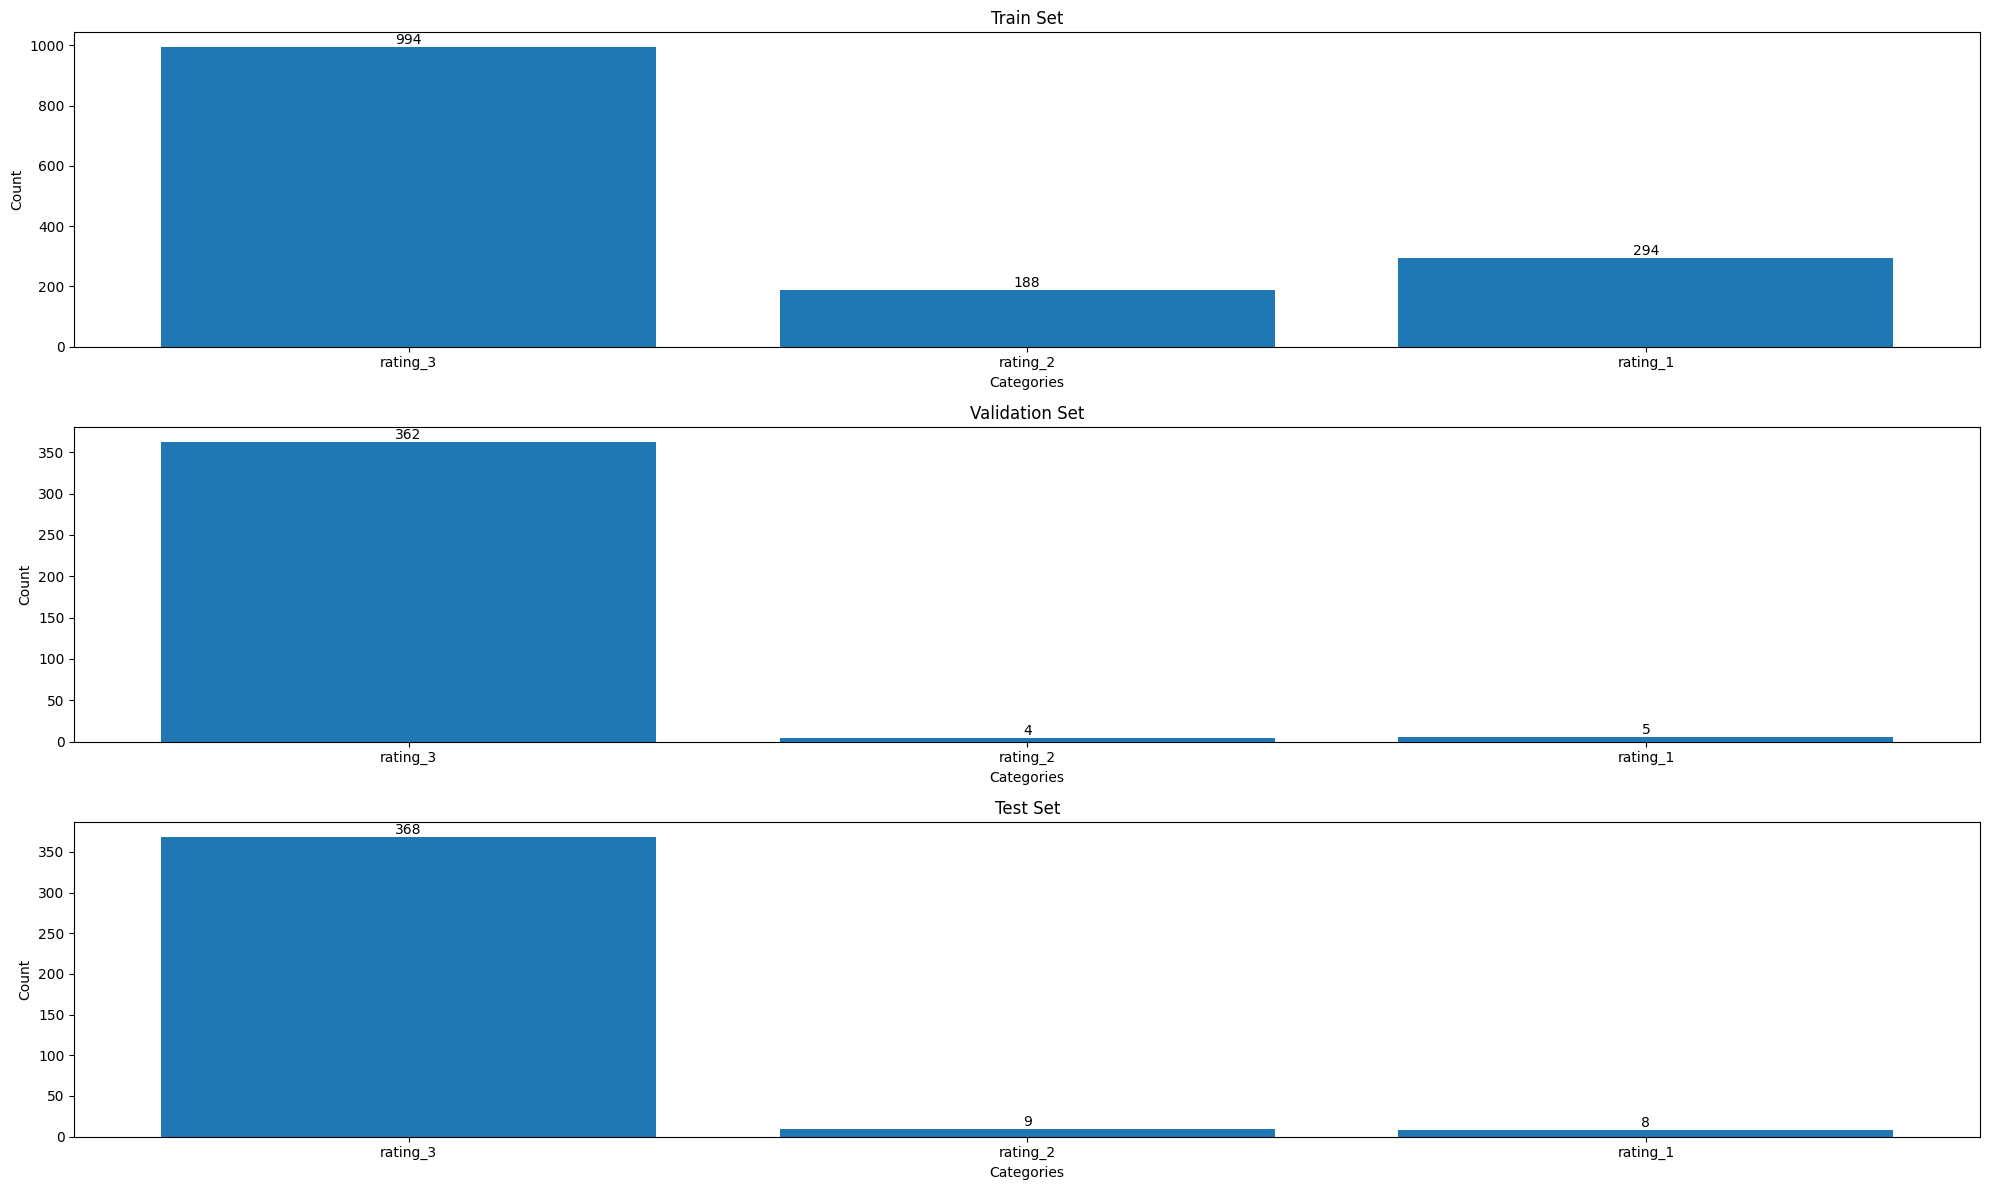

In [13]:
dataset_folder = base_dir
categories = os.listdir(os.path.join(base_dir, 'train'))

data_splits = ['train', 'validation', 'test']

counts = {split: {category: 0 for category in categories} for split in data_splits}

for split in data_splits:
    for category in categories:
        category_folder = os.path.join(dataset_folder, split, category)
        counts[split][category] = len(os.listdir(category_folder))

fig, axes = plt.subplots(3, 1, figsize=(20, 12))

for i, split in enumerate(data_splits):
    ax = axes[i]
    categories_counts = [counts[split][category] for category in categories]
    bars = ax.bar(categories, categories_counts)
    ax.set_title(f'{split.capitalize()} Set')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count')

    for i in not_splitted:
      i = i.lower().replace(" ", "_")
      bars[categories.index(i)].set_color('royalblue')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

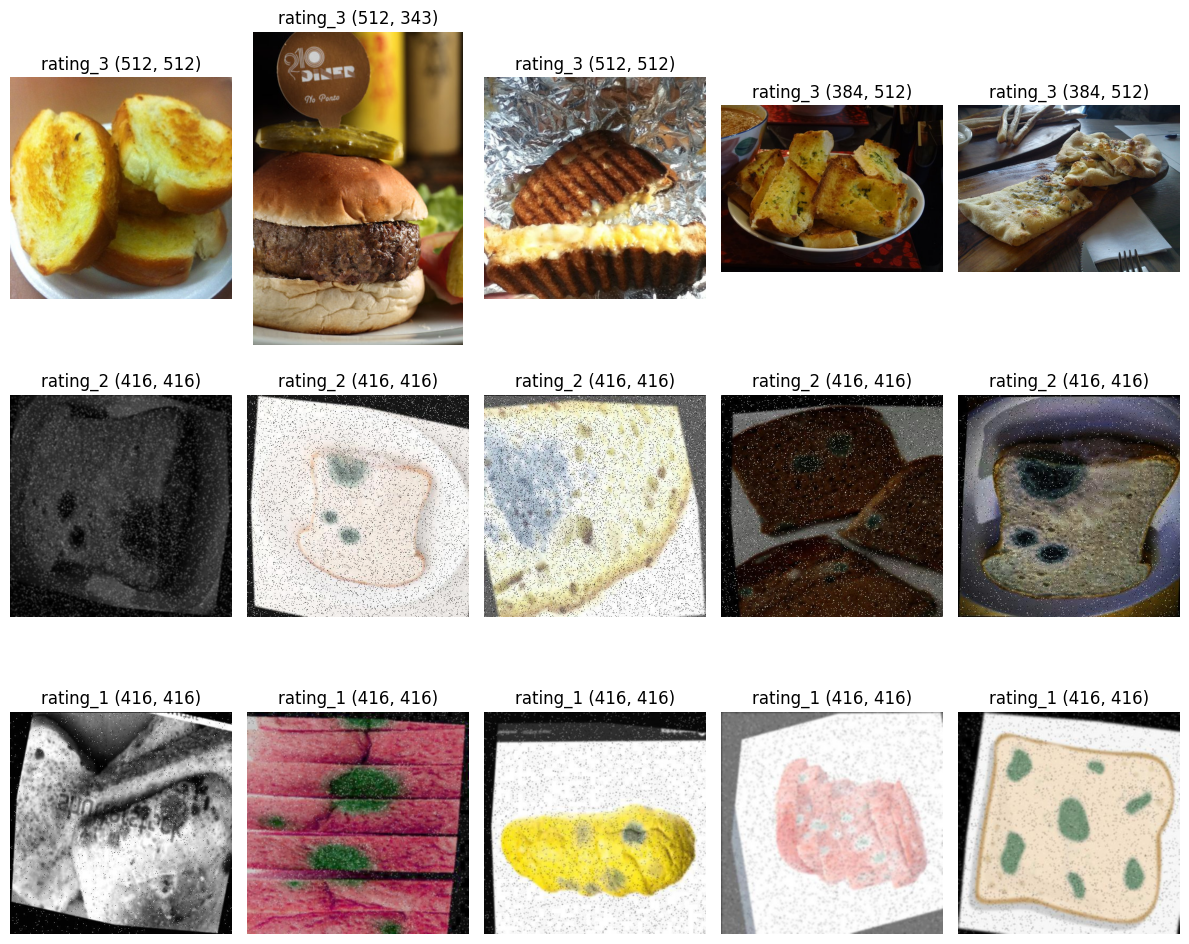

In [14]:
class_count = len(categories)
examples = 5

fig, ax = plt.subplots(class_count, examples, figsize=(12, 10))


for i, category in enumerate(categories):
  category_dir = os.path.join(base_dir, 'train', category)
  image_files = os.listdir(category_dir)

  for j in range(examples):
    rdm = np.random.randint(0, len(image_files))
    img_path = os.path.join(category_dir, image_files[rdm])
    img = mpimg.imread(img_path)
    ax[i, j].imshow(img)
    ax[i, j].set_title(f'{category} {img.shape[:2]}')
    ax[i, j].axis('off')

plt.tight_layout()

plt.show()

## Data Augmentation

In [15]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

test_generator = validation_datagen.flow_from_directory(
	test_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

Found 1476 images belonging to 3 classes.
Found 371 images belonging to 3 classes.
Found 385 images belonging to 3 classes.


## Building Model

In [16]:
input_shape = (224, 224, 3)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu",kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu",kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation="relu",kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    Dropout(0.5),
    tf.keras.layers.Dense(512, activation="relu",kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(128, activation="relu",kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(3, activation="softmax",kernel_regularizer=l2(0.001))
])
model.summary()

ValueError: ignored

In [17]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['acc'])

## Model Training

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(train_generator, epochs=25, validation_data = validation_generator)

Epoch 1/25
 5/47 [==>...........................] - ETA: 7:36 - loss: 2.2396 - acc: 0.5188

## Model Evaluation

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [ ]:
results = model.evaluate(test_generator, batch_size=32)

## Transfer Learning

In [ ]:
input_shape = (224, 224, 3)

resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

In [ ]:
resnet_model.trainable = False

In [ ]:
inputs = Input(shape=input_shape)
x = resnet_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(3, activation="softmax")(x)
tl_model = Model(inputs=inputs, outputs=outputs)
tl_model.summary()

In [ ]:
tl_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
tl_hist = tl_model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
    callbacks=[early_stopping]
)

## Model Evaluation

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(tl_hist.history['accuracy'])
plt.plot(tl_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(tl_hist.history['loss'])
plt.plot(tl_hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [ ]:
results = tl_model.evaluate(test_generator, batch_size=32)

## Save Model

In [ ]:
MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    tl_model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

In [ ]:
!zip -r model.zip /tmp/1